In [68]:
import pysm
import numpy as np
import healpy as hp
from pysm.nominal import models
from pysm.common import convert_units
import matplotlib.pyplot as plt
%matplotlib inline

In [24]:
nu = np.array([30., 44., 70., 95., 150., 217., 353.]) 
coefficients = convert_units("uK_RJ", "uK_CMB", nu)
Nf = len(nu)

In [25]:
nside = 1024

In [26]:
def convert_unit(map):
    for i in range(0,Nf):
        map[i] = map[i]*coefficients[i]
    return map

In [27]:
c1_config = models("c1", nside)       
s1_config = models("s1", nside)
d1_config = models("d1", nside)
f1_config = models("f1", nside)
a1_config = models("a1", nside)
sky_config = {
    'synchrotron' : s1_config,
    'dust' : d1_config,
    'freefree' : f1_config,
    'cmb' : c1_config,
    'ame' : a1_config
}
sky = pysm.Sky(sky_config) 

#dust = sky.dust(nu);synchrotron = sky.synchrotron(nu);freefree = sky.freefree(nu)
#cmb = sky.cmb(nu); ame = sky.ame(nu)
#np.save('../simulation/Nside = 1024/dust_map.npy',convert_unit(dust)); np.save('../simulation/Nside = 1024/synchro_map.npy',convert_unit(synchrotron));
#np.save('../simulation/Nside = 1024/9_fre/cmb_map.npy',convert_unit(cmb)); #np.save('../simulation/Nside = 1024/freefree_map.npy',convert_unit(freefree));
#np.save('../simulation/Nside = 1024/ame_map.npy',convert_unit(ame))

total = sky.signal()(nu)
total_map = convert_unit(total)

In [166]:
cmb_map = coefficients[0]*sky.cmb(30)

In [28]:
total_I = np.copy(total_map[0][0])
for i in range(Nf-1):
    total_I = np.row_stack((total_I, total_map[i+1][0]))

In [143]:
cov = np.zeros((Nf, Nf))

for i in range(Nf):
#     mean_i = np.mean(total_I[i])
    for j in range(Nf):
#         mean_j = np.mean(total_I[j])
#         for k in range(12*nside**2):
#             cov[i,j] += (total_I[i][k] - mean_i)*(total_I[j][k] - mean_j)
        cov[i, j] = np.dot(total_I[i] - np.mean(total_I[i]), total_I[j] - np.mean(total_I[j]))/12.0/nside**2
# cov = cov/12.0/nside**2

In [180]:
cov_inv = np.linalg.pinv(cov)

In [181]:
w = np.zeros(Nf)
for i in range(Nf):
    w[i] = np.sum(cov_inv[i,:])/np.sum(cov_inv)

In [209]:
cmb_ILC = np.dot(w, total_I)

In [219]:
cl_ILC_pix = hp.anafast(cmb_ILC)

In [214]:
def Power_spectrum(maps,R, lmax):
    global cl
    ''' revised for upper-triangle of the matrix '''
    n_f = len(maps)
#     print(n_f)
    cl = np.ones((n_f*n_f, lmax +1)); Cl = np.zeros((lmax+1, n_f, n_f))
    k = 0
    for i in range(n_f):
        for j in range(n_f):
            
            if i >= j :
                cross_ps = hp.anafast(maps[i], maps[j], lmax = lmax, gal_cut=R)
            else:
                cross_ps = np.zeros(lmax+1) ## TT, EE, BB
            cl[k] = cross_ps  ## calculate the B_mode power spectrum 
            k += 1
#     print(cl.shape)
    for l in range(lmax+1):
        Cl[l, 0:n_f , 0:n_f] = cl[:,l].reshape(n_f, n_f)
        Cl[l] += Cl[l].T - np.diag(Cl[l].diagonal()) 
    return Cl

In [315]:
L = 2000; Q = int(L/10.0); Ell = np.ones(Q)
def bin_l(cl):
    if len(cl.shape) > 2 :
        bin_averages = np.zeros((Q, cl.shape[1], cl.shape[1]))
    else:
        bin_averages = np.zeros(Q)
#     for l in range(L):
#         cl[l] = l*(l+1)/2/np.pi*(cl[l])    
    for q in range(Q):
        bin_averages[q] = (sum(cl[q*L//Q:((q+1)*L//Q)]/(L//Q)))
    return bin_averages

for i in range(0,int(Q)):
    Ell[i] = (2*i+1)*L//Q/2 

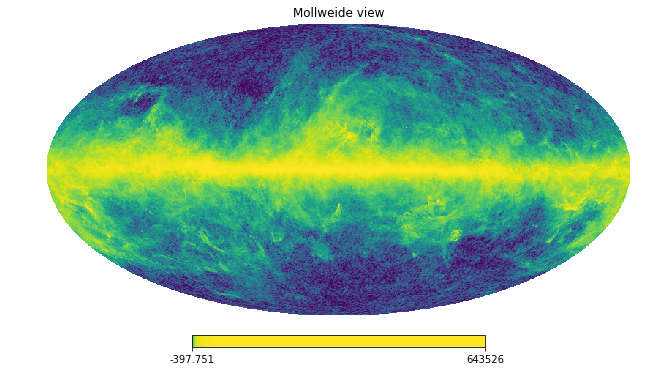

In [238]:
hp.mollview(total_I[6], norm = 'hist')

In [215]:
total_ps= Power_spectrum(total_I, 0, 2000)

In [273]:
total_ps[0]

array([[2.35855776e+06, 9.39234463e+05, 4.41092228e+05, 4.33400317e+05,
        8.14707129e+05, 2.13813801e+06, 1.60903678e+07],
       [9.39234463e+05, 3.74025767e+05, 1.75653540e+05, 1.72590436e+05,
        3.24435986e+05, 8.51458010e+05, 6.40757168e+06],
       [4.41092228e+05, 1.75653540e+05, 8.24920874e+04, 8.10535634e+04,
        1.52364715e+05, 3.99869815e+05, 3.00918480e+06],
       [4.33400317e+05, 1.72590436e+05, 8.10535634e+04, 7.96401248e+04,
        1.49707730e+05, 3.92896754e+05, 2.95670965e+06],
       [8.14707129e+05, 3.24435986e+05, 1.52364715e+05, 1.49707730e+05,
        2.81421009e+05, 7.38568418e+05, 5.55803108e+06],
       [2.13813801e+06, 8.51458010e+05, 3.99869815e+05, 3.92896754e+05,
        7.38568418e+05, 1.93831765e+06, 1.45866374e+07],
       [1.60903678e+07, 6.40757168e+06, 3.00918480e+06, 2.95670965e+06,
        5.55803108e+06, 1.45866374e+07, 1.09770445e+08]])

In [218]:
cmb_cls = hp.anafast(cmb_map[0], lmax = 2000)


In [317]:
cls = bin_l(cmb_cls)

In [318]:

e = np.matrix(np.ones(Nf))
total_bin = bin_l(total_ps)
# total_bin = total_ps
cl_ilc = np.zeros(Q)
#calculate the weight
W = np.matrix(np.zeros((Q, Nf)))
for l in range(Q):
    norm = e*np.linalg.pinv((total_bin[l]))*e.T
    W[l,:] = e*np.linalg.pinv((total_bin[l]))/norm   
    
for i in range(Q):
#     noise_ilc[i] = W[i,:]*(noise_bin[i])*np.transpose(W[i,:])
    cl_ilc[i] = 1.0/(e*np.linalg.pinv((total_bin[i]))*e.T) #- noise_ilc[i]

In [319]:
cls_ILC_pix_bin = bin_l(cl_ILC_pix)

(200, 1400)

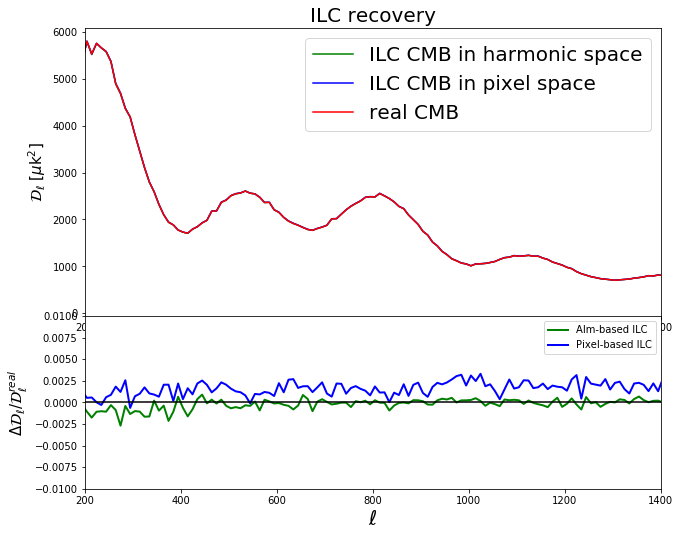

In [322]:
fig1 = plt.figure(1, figsize=(10,8))
plt.axis('off')
frame1=fig1.add_axes((.1,.4,.8,.5)) # x0, y0, width, height
# plt.xlim(2, 200)
s = 2; e = 200
plt.plot(Ell[s:e], Ell[s:e]*(Ell[s:e]+1)/2/np.pi*cl_ilc[s:e], 'g-', label = 'ILC CMB in harmonic space')
plt.plot(Ell, Ell*(Ell+1)/2/np.pi*cls_ILC_pix_bin, 'b-', label = 'ILC CMB in pixel space')
plt.plot(Ell, Ell*(Ell+1)/2/np.pi*cls, 'r-',label = 'real CMB')
# plt.loglog(Ell, Ell*(Ell+1)/2/np.pi*noise_ilc, 'b--', label = 'noise_ilc')
# plt.ylim(2, 6500); 
# plt.loglog(Ell, Ell*(Ell+1)/2/np.pi*cl_extra, 'b-',label = 'extra CMB')
plt.xlim(200, 1400)

plt.xlabel('$\ell$', fontsize = 20); 
plt.ylabel(r'$\mathcal{D}_{\ell}$ [$\mu$k$^2$]', fontsize = 15)
plt.legend(fontsize = 20)
# plt.title('ILC in harmonical space, subtracting %s * dust'%frac, fontsize = 20)
plt.title('ILC recovery', fontsize = 20)
# plt.xlim(0, 2000)
frame2=fig1.add_axes((.1,.1,.8,.3))
plt.plot(Ell, (cl_ilc - cls)/cls, 'g-',lw = 2,  label = 'Alm-based ILC') 
plt.plot(Ell, (cls_ILC_pix_bin - cls)/cls, 'b-', lw = 2, label = 'Pixel-based ILC')
plt.legend()
plt.axhline(0,color = 'k')
plt.ylabel(r'$\Delta \mathcal{D}_\ell$/$\mathcal{D}^{real}_{\ell} $ ', fontsize = 15);plt.xlabel(r'$\ell$', fontsize = 20)
plt.ylim(-0.01, 0.01)
plt.xlim(200, 1400)


In [303]:
(cls_ILC_pix_bin - cls)/cls

array([ 2.66684202e+02,  1.90906630e+03, -3.17839196e-02, ...,
        6.77517536e-03,  1.03338006e-02,  4.87206817e-03])